# TITLE

# Dataset setup

This was really messy and time-consuming.

To set up data, do:
- Download zip files
- Convert to YOLO format
    - for now we do CFC/images/train and CFC/labels/train etc
    - Remember adding empty .txt files for background images (images with no instance)
    - write yaml file
- Run summary script to see if ok


### Make labels on right format. COCO -> YOLO

In [ ]:
# import json, os
# from pathlib import Path
# from collections import defaultdict

# ROOT   = Path("../data/CFC")
# IMAGES = ROOT / "images/val"

# SPLIT_DIR = {"train": "cfc_train", "val": "cfc_val", "test": "cfc_test"}

# def clip(v, lo, hi): return max(lo, min(hi, v))

# def resolve_image_path(file_name, split):
#     # Try the real split dir first
#     p = IMAGES / SPLIT_DIR.get(split, split) / file_name
#     if p.exists():
#         return p
#     # Fallbacks if JSON already contains subdirs or files are at root
#     q = IMAGES / file_name
#     if q.exists():
#         return q
#     r = IMAGES / split / file_name
#     return r  # may not exist; caller will check

# def convert(split, coco_json):
#     labels_dir = ROOT / "labels" / split
#     labels_dir.mkdir(parents=True, exist_ok=True)
#     coco = json.loads(Path(coco_json).read_text())

#     id2img = {im["id"]: im for im in coco["images"]}
#     byimg = defaultdict(list)
#     for a in coco["annotations"]:
#         if a.get("iscrowd", 0) == 1 or a.get("ignore", 0) == 1:
#             continue
#         byimg[a["image_id"]].append(a)

#     sorted_cats = sorted(coco["categories"], key=lambda c: c["id"])
#     cat2idx = {c["id"]: i for i, c in enumerate(sorted_cats)}

#     written = missing = 0
#     for img_id, img in id2img.items():
#         img_path = resolve_image_path(img["file_name"], split)
#         if not img_path.exists():
#             missing += 1
#             continue

#         W, H = img["width"], img["height"]
#         lines = []
#         for ann in byimg.get(img_id, []):
#             x, y, w, h = ann["bbox"]
#             x = clip(x, 0, W); y = clip(y, 0, H)
#             w = clip(w, 0, W - x); h = clip(h, 0, H - y)
#             if w <= 0 or h <= 0: 
#                 continue
#             xc = (x + w / 2) / W
#             yc = (y + h / 2) / H
#             wn = w / W
#             hn = h / H
#             cls = cat2idx[ann["category_id"]]
#             lines.append(f"{cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")

#         if lines:
#             (labels_dir / (Path(img["file_name"]).stem + ".txt")).write_text("\n".join(lines))
#             written += 1

#     print(f"{split}: wrote labels for {written} images; missing files: {missing}")

# #convert("train", ROOT/"CFC_ANN"/"cfc_train.json")
# convert("val",   ROOT/"CFC_ANN"/"cfc_val.json")


val: wrote labels for 9925 images; missing files: 0


### check if paths are ok


In [ ]:
# from pathlib import Path
# import os, shutil

# # Paths
# NOT_ROOT = Path.cwd()              
# ROOT = NOT_ROOT.parent
# DATA = ROOT / "data" / "CFC"



# # Define paths
# IMAGES_TRAIN = DATA / "images" / "train"
# IMAGES_VAL   = DATA / "images" / "val"
# LABELS_TRAIN = DATA / "labels" / "train"
# LABELS_VAL   = DATA / "labels" / "val"

# # Check everything exists
# for p in [IMAGES_TRAIN, IMAGES_VAL, LABELS_TRAIN, LABELS_VAL]:
#     print(p, "✅ OK" if p.exists() else "❌ MISSING")


/Users/henrik/kode/SP/aqua_yolo/data/CFC/images/train ✅ OK
/Users/henrik/kode/SP/aqua_yolo/data/CFC/images/val ✅ OK
/Users/henrik/kode/SP/aqua_yolo/data/CFC/labels/train ✅ OK
/Users/henrik/kode/SP/aqua_yolo/data/CFC/labels/val ✅ OK


### (Optional) Grayscale convertion

In [13]:
import cv2
from pathlib import Path

in_dir = Path("../data/CFC/images/val")
out_dir = Path("../data/CFC_gray/images/val")
out_dir.mkdir(parents=True, exist_ok=True)

valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

count = 0
for p in in_dir.rglob("*.*"):
    if p.suffix.lower() not in valid_extensions:
        continue
    
    img = cv2.imread(str(p), cv2.IMREAD_COLOR)
    
    if img is None:
        print(f"Failed to load image: {p}")
        continue

    # Convert to grayscale and replicate to 3 channels
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    g3 = cv2.cvtColor(g, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(str(out_dir / p.name), g3)
    count +=1
    if count%1000==0: 
        print(count)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
Failed to load image: ../data/CFC/images/val/2018-06-03-JD154_LeftNear_Stratum1_Set1_LN_2018-06-03_030000_1888_2429_142.jpg
25000
26000
27000
28000
29000
30000


In [1]:
import os
from pathlib import Path

ROOT = Path("../data/CFC_gray")
IMG_DIRS = [
    ROOT/"images"/"train",
    ROOT/"images"/"val",
    ROOT/"images"/"test",
]

deleted = 0
for d in IMG_DIRS:
    if d.exists():
        for p in d.rglob("*.npy"):
            p.unlink()
            deleted += 1

# also remove stale .cache files Ultralytics might have created
cache_deleted = 0
for p in ROOT.rglob("*.cache"):
    p.unlink()
    cache_deleted += 1

print(f"Deleted {deleted} .npy files.")
print(f"Deleted {cache_deleted} .cache files.")


Deleted 107072 .npy files.
Deleted 2 .cache files.


### Write yaml

In [1]:
from pathlib import Path

# Base paths
NOT_ROOT = Path.cwd()
ROOT = NOT_ROOT.parent

DATA = ROOT / "data" / "CFC"

IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA    / "images" / "val"


# Build YAML (classic YOLO: train/val/test point to images dirs)
dataset_yaml = f"""
path: {DATA.as_posix()}
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}


nc: 1
names: 
    - fish
"""

# Write YAML next to the dataset
yaml_path = DATA / "cfc.yaml"
yaml_path.write_text(dataset_yaml.strip() + "\n", encoding="utf-8")

print("Wrote:", yaml_path)
print("\nPreview:\n")
print(dataset_yaml)


Wrote: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/CFC/cfc.yaml

Preview:


path: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/CFC
train: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/CFC/images/train
val:   /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/CFC/images/val


nc: 1
names: 
    - fish



### Visualize

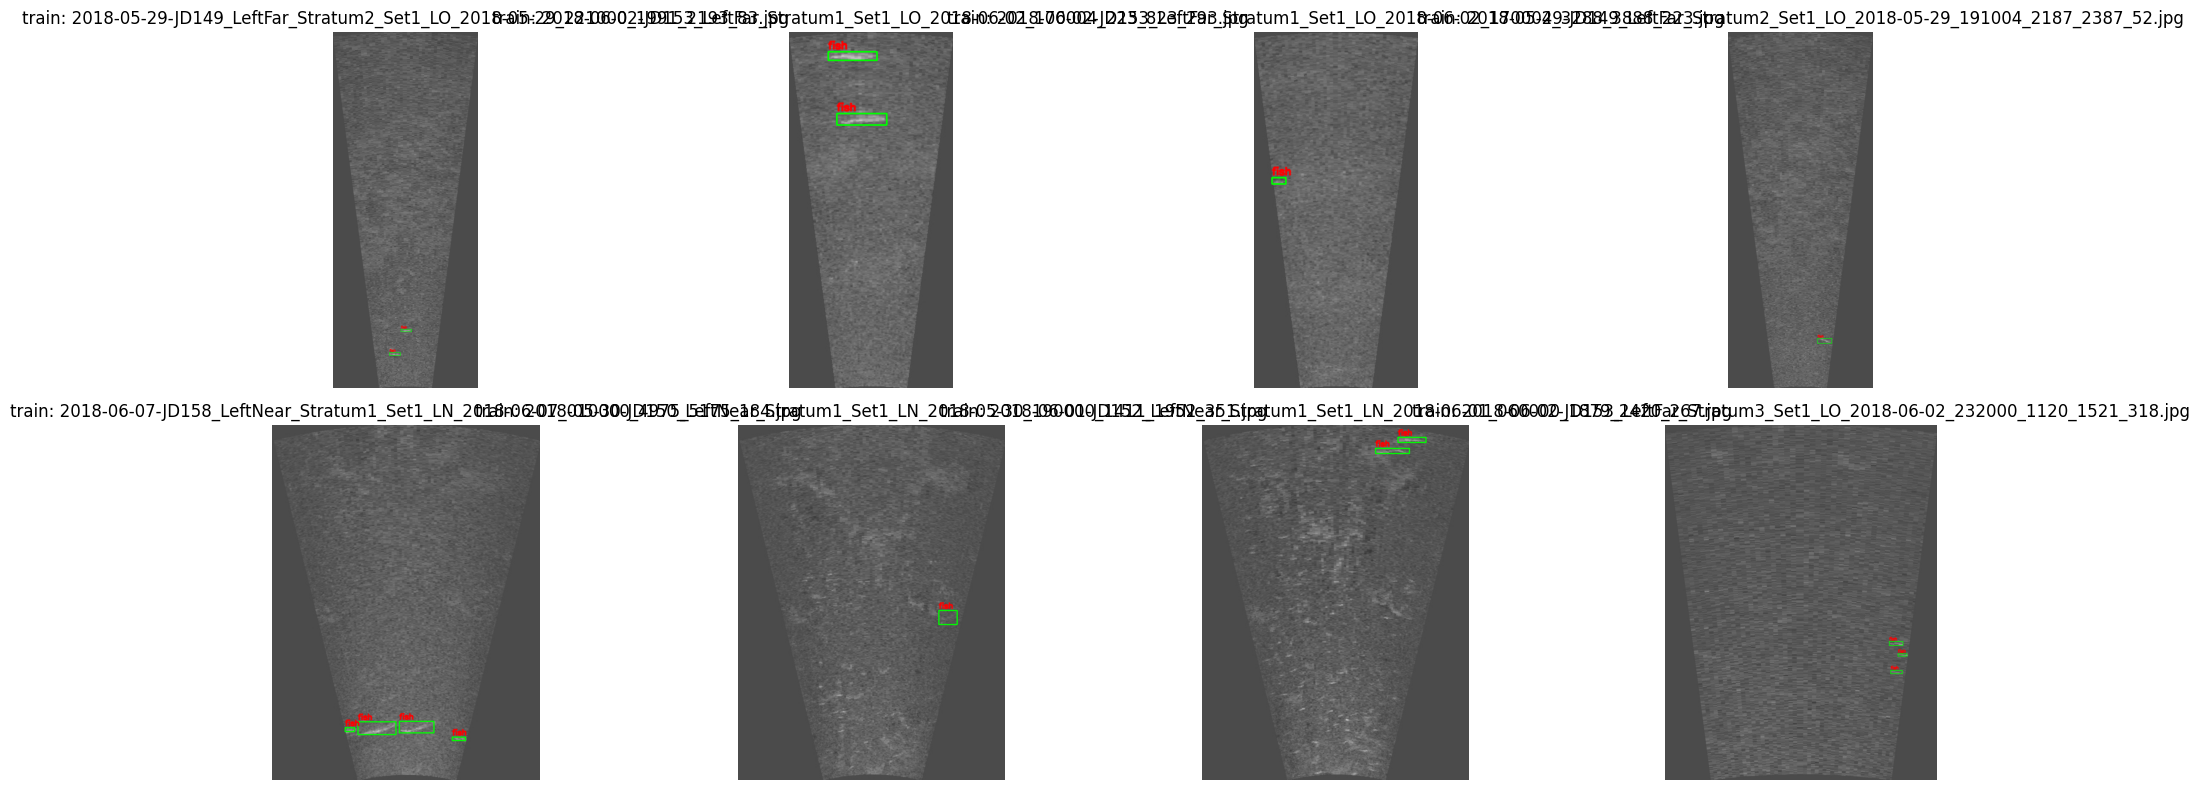

In [4]:
import os, math, random, re
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

# ---------------- config ----------------
DATA_ROOT = Path("../data/CFC_gray")
IMG_ROOT  = DATA_ROOT / "images"
LAB_ROOT  = DATA_ROOT / "labels"

SPLIT = "train"   # "train" or "test"
IMG_DIR = IMG_ROOT / SPLIT
LAB_DIR = LAB_ROOT / SPLIT

NUM_PICS = 8
COLS = 4


CFC_NAMES = [
    "fish"
]
# ----------------------------------------

def find_images(folder: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def label_path_for(img_path: Path) -> Path:
    return LAB_DIR / (img_path.stem + ".txt")

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        # YOLO format: class cx cy w h (normalized 0..1)
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        color = (0,255,0)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2, cv2.LINE_AA)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# collect images that exist (optionally: require label file exists too)
all_imgs = find_images(IMG_DIR)
imgs_with_labels = [p for p in all_imgs if label_path_for(p).exists()]
pool = imgs_with_labels if imgs_with_labels else all_imgs

if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_ids = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_ids) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for idx, img_path in enumerate(sample_ids, 1):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    lab_path = label_path_for(img_path)
    vis = draw_yolo_labels(img_bgr, lab_path, CFC_NAMES)

    plt.subplot(rows, COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SPLIT}: {img_path.name}")
plt.tight_layout(); plt.show()


### Dataset summary

In [3]:
#!/usr/bin/env python3
# summarize_cfc_dataset.py
#
# Prints a clean summary of your CFC YOLO dataset.
# Layout assumed:
#   data/CFC/CFC_pic/{cfc_train,cfc_val[,cfc_test]}/<images>
#   data/CFC/labels/{train,val[,test]}/*.txt

from pathlib import Path
import glob

# ----- CONFIG -----
ROOT = Path("../data/CFC_gray")
IMG_ROOT = ROOT / "images"
LBL_ROOT = ROOT / "labels"

# Map YOLO split name -> actual images subfolder name in your tree
SPLIT_DIR = {"train": "train", "val": "val", "test": "cfc_test"}
SPLITS = [s for s in ("train", "val", "test") if (IMG_ROOT / SPLIT_DIR[s]).exists()]

CFC_CLASSES = ["fish"]  # edit if you add classes
NUM_CLASSES = len(CFC_CLASSES)

# Image filename patterns to recognize
IMG_PATTERNS = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tif", "*.tiff"]

EPS = 1e-9
# ------------------

def list_image_stems(dirpath: Path):
    stems = set()
    for pat in IMG_PATTERNS:
        stems |= {Path(p).stem for p in glob.glob(str(dirpath / pat))}
    return stems

def list_label_stems(dirpath: Path):
    return {Path(p).stem for p in glob.glob(str(dirpath / "*.txt"))}

def validate_line(parts):
    """Return None if ok, else a reason string."""
    if len(parts) < 5:
        return f"expected 5 values 'cls cx cy w h', got {len(parts)}"
    try:
        cls = int(float(parts[0]))
        cx, cy, w, h = map(float, parts[1:5])
    except Exception as e:
        return f"parse error: {e}"
    if not (0 <= cls < NUM_CLASSES):
        return f"class {cls} not in [0..{NUM_CLASSES-1}]"
    if not (0.0 <= cx <= 1.0 and 0.0 <= cy <= 1.0):
        return f"center out of range (cx={cx:.6f}, cy={cy:.6f})"
    if not (w > EPS and h > EPS and w <= 1.0 and h <= 1.0):
        return f"invalid box size (w={w:.6f}, h={h:.6f})"
    return None

def summarize_split(split: str):
    img_dir = IMG_ROOT / SPLIT_DIR.get(split, split)
    lbl_dir = LBL_ROOT / split

    imgs = list_image_stems(img_dir) if img_dir.exists() else set()
    lbls = list_label_stems(lbl_dir) if lbl_dir.exists() else set()

    missing_images = sorted(lbls - imgs)
    missing_labels = sorted(imgs - lbls)

    per_class = [0] * NUM_CLASSES
    instances = 0
    invalid_lines = 0

    for stem in sorted(lbls & imgs):
        path = lbl_dir / f"{stem}.txt"
        try:
            with open(path, "r") as f:
                for raw in f:
                    line = raw.strip()
                    if not line:
                        invalid_lines += 1
                        continue
                    parts = line.split()
                    err = validate_line(parts)
                    if err:
                        invalid_lines += 1
                        continue
                    cls = int(float(parts[0]))
                    per_class[cls] += 1
                    instances += 1
        except Exception:
            invalid_lines += 1

    images_with_labels = len(lbls & imgs)
    everything_valid = (len(missing_images) == 0 and len(missing_labels) == 0 and invalid_lines == 0)

    return {
        "split": split,
        "images_total": len(imgs),
        "labels_total": len(lbls),
        "images_with_labels": images_with_labels,
        "instances": instances,
        "per_class": per_class,
        "missing_images": len(missing_images),
        "missing_labels": len(missing_labels),
        "invalid_lines": invalid_lines,
        "valid": everything_valid,
    }

def print_summary(results):
    print("\n=== CFC YOLO Dataset Summary ===\n")

    grand_images = grand_instances = 0
    grand_valid = True
    agg_per_class = [0] * NUM_CLASSES

    for r in results:
        grand_images += r["images_total"]
        grand_instances += r["instances"]
        grand_valid = grand_valid and r["valid"]
        agg_per_class = [a + b for a, b in zip(agg_per_class, r["per_class"])]

        print(f"[{r['split']}]")
        print(f"  Images (total):         {r['images_total']}")
        print(f"  Images (with labels):   {r['images_with_labels']}")
        print(f"  Labels (files):         {r['labels_total']}")
        print(f"  Instances:              {r['instances']}")
        print(f"  Valid:                  {'YES' if r['valid'] else 'NO'}"
              f"  (invalid_lines={r['invalid_lines']}, missing_imgs={r['missing_images']}, missing_lbls={r['missing_labels']})")

        width = max(len(c) for c in CFC_CLASSES)
        print("  Per-class instances:")
        for i, c in enumerate(CFC_CLASSES):
            print(f"    {i:2d}  {c.ljust(width)} : {r['per_class'][i]}")
        print("")

    print("=== Totals ===")
    print(f"  Images (total across splits): {grand_images}")
    print(f"  Instances (total):            {grand_instances}")
    print("  Per-class totals:")
    width = max(len(c) for c in CFC_CLASSES)
    for i, c in enumerate(CFC_CLASSES):
        print(f"    {i:2d}  {c.ljust(width)} : {agg_per_class[i]}")
    print(f"\nEverything valid across splits: {'YES' if grand_valid else 'NO'}\n")

def main():
    if not SPLITS:
        print("No splits found under", IMG_ROOT)
        return
    results = [summarize_split(s) for s in SPLITS]
    print_summary(results)

if __name__ == "__main__":
    main()


KeyboardInterrupt: 

# Building

Building (and training) of the model happens in [train.py](../train.py). The model is constructed by the [aquayolo.yaml](../models/aquayolo.yaml), that imports modules from custom blocks (see paragraph below).

### Adding custom blocks

I have added custom blocks to match the architecture as pruposed in the paper. For this to work I have first cloned the ultralytics repo.
- Head to [ultralytics](https://docs.ultralytics.com/guides/model-yaml-config/#source-code-modification) to see how to add custom blocks.
- Files that is modified: [block.py](../../ultralytics/ultralytics/nn/modules/block.py) (classes: AquaResidualBlock, DSAM), [tasks.py](../../ultralytics/ultralytics/nn/tasks.py) (added imports and updated parse_model() for special arguments), [__init__.py](../../ultralytics/ultralytics/nn/modules/__init__.py) (exposing the modules).



# Training

- To train the model run the train.py script by doing: `python3 train.py`

Train.py script:

```bash

# train.py

from ultralytics import YOLO


if __name__ == "__main__":
    
    # Load custom model cfg
    m = YOLO("models/aquayolo.yaml")
    m.info()  # non-zero FLOPs confirms forward path OK

    m.train(
        data="data/CFC_gray/cfc_gray.yaml",
        pretrained=False,          # Safest off
        epochs=60, 
        imgsz=640,
        batch=512,
        nbs=512,


    # optimizer
        optimizer="AdamW",
        lr0=3e-4,
        weight_decay=0.01,
        cos_lr=True,
        lrf=0.01,
        warmup_epochs=3,
        patience=20,            


    # loss balance – tilt a bit toward recall
        box=10.0, cls=0.6, dfl=1.3,


    # sonar-friendly aug, we do nothing really, is this ok?
        auto_augment=None,  
        # geometry
        degrees=0.0,          # no rotation (shadow direction is meaningful)
        shear=0.0,
        perspective=0.0,
        translate=0.02,       # small shifts are ok
        scale=0.35,            # Ultralytics default scale jitter; fine for sonar

        # photometrics
        hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,  # disable HSV for gray-scale sonar

        # composition
        mosaic=0.0,           # off (mosaic creates unrealistic seabed continuity)
        mixup=0.0,            # off (blends break acoustic edges)
        copy_paste=0.0,       # off (unlikely to preserve shadows correctly)

        # flips
        fliplr=0.05,           # small chance; left/right symmetry may be acceptable
        flipud=0.0,           # avoid flipping seabed “upside-down”

        # occlusion-like
        erasing=0.15,          # light Random Erasing to mimic dropouts/occlusions
        
    

        
    # system
        workers=8,                 # safe
        device=[0, 1, 2, 3],
        project="runs_aquayolo",
        name="cfc_gray_adamW_m",
        seed=0,
        plots=False,
        cache=False,
        amp=False,  
    )

```



### How I did training

- Using the IDUN computer at NTNU. 
    - Idun settings: 4 GPUS (H200). 64 CPU cores, 256 GB RAM, 



# Evalutation

# cfc trained, cfc tested

### Get results 

In [2]:
from ultralytics import YOLO
model = YOLO("../runs_aquayolo/cfc_gray_adamW_m/weights/best.pt")
results = model.val(
    data="../data/CFC_gray/cfc_gray.yaml",
    imgsz=640,
    batch=1,
    iou=0.7,
    plots=True,
    project="../runs_aquayolo",
    name="EVAL_cfc_gray_m",
    exist_ok=True
)


Ultralytics 8.3.213 🚀 Python-3.9.21 torch-2.8.0+cu128 CUDA:0 (NVIDIA H200, 143156MiB)
aquaYOLO summary: 301 layers, 56,841,107 parameters, 0 gradients, 169.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 451.1±360.6 MB/s, size: 124.6 KB)
val: Scanning /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/CFC_gray/labels/val.cache... 30453 images, 20528 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 30453/30453 56.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 30453/30453 94.1it/s 5:23<0.0s
                   all      30453      18551      0.829       0.57      0.648      0.295
Speed: 0.1ms preprocess, 9.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/runs_aquayolo/EVAL_cfc_gray_m


### Show images

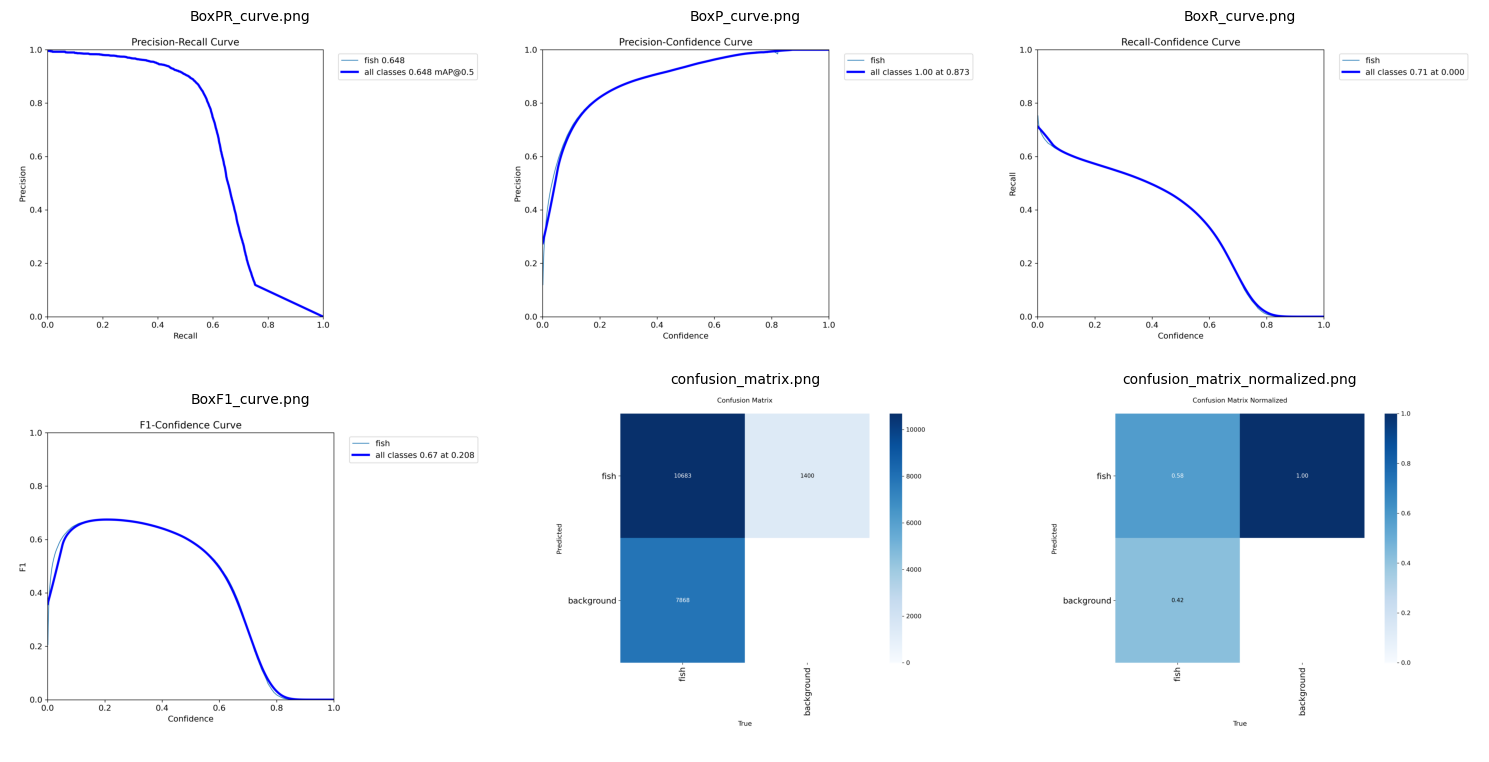

In [3]:
import matplotlib.pyplot as plt
from IPython.display import display
import os
import matplotlib.image as mpimg

%matplotlib inline

run_dir = "../runs_aquayolo/EVAL_cfc_gray_m"

# Curves + confusion matrices
to_show = [
    "BoxPR_curve.png",      # PR curve (per class)
    "BoxP_curve.png",       # Precision vs conf
    "BoxR_curve.png",       # Recall vs conf
    "BoxF1_curve.png",      # F1 vs conf
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
]

# Load all available images
images = []
titles = []
for f in to_show:
    path = os.path.join(run_dir, f)
    if os.path.exists(path):
        img = mpimg.imread(path)
        images.append(img)
        titles.append(f)
    else:
        print(f"⚠️ missing: {f}")

# --- Plot 2x3 grid ---
cols = 3
rows = (len(images) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(titles[i], fontsize=10)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


### Show predictions

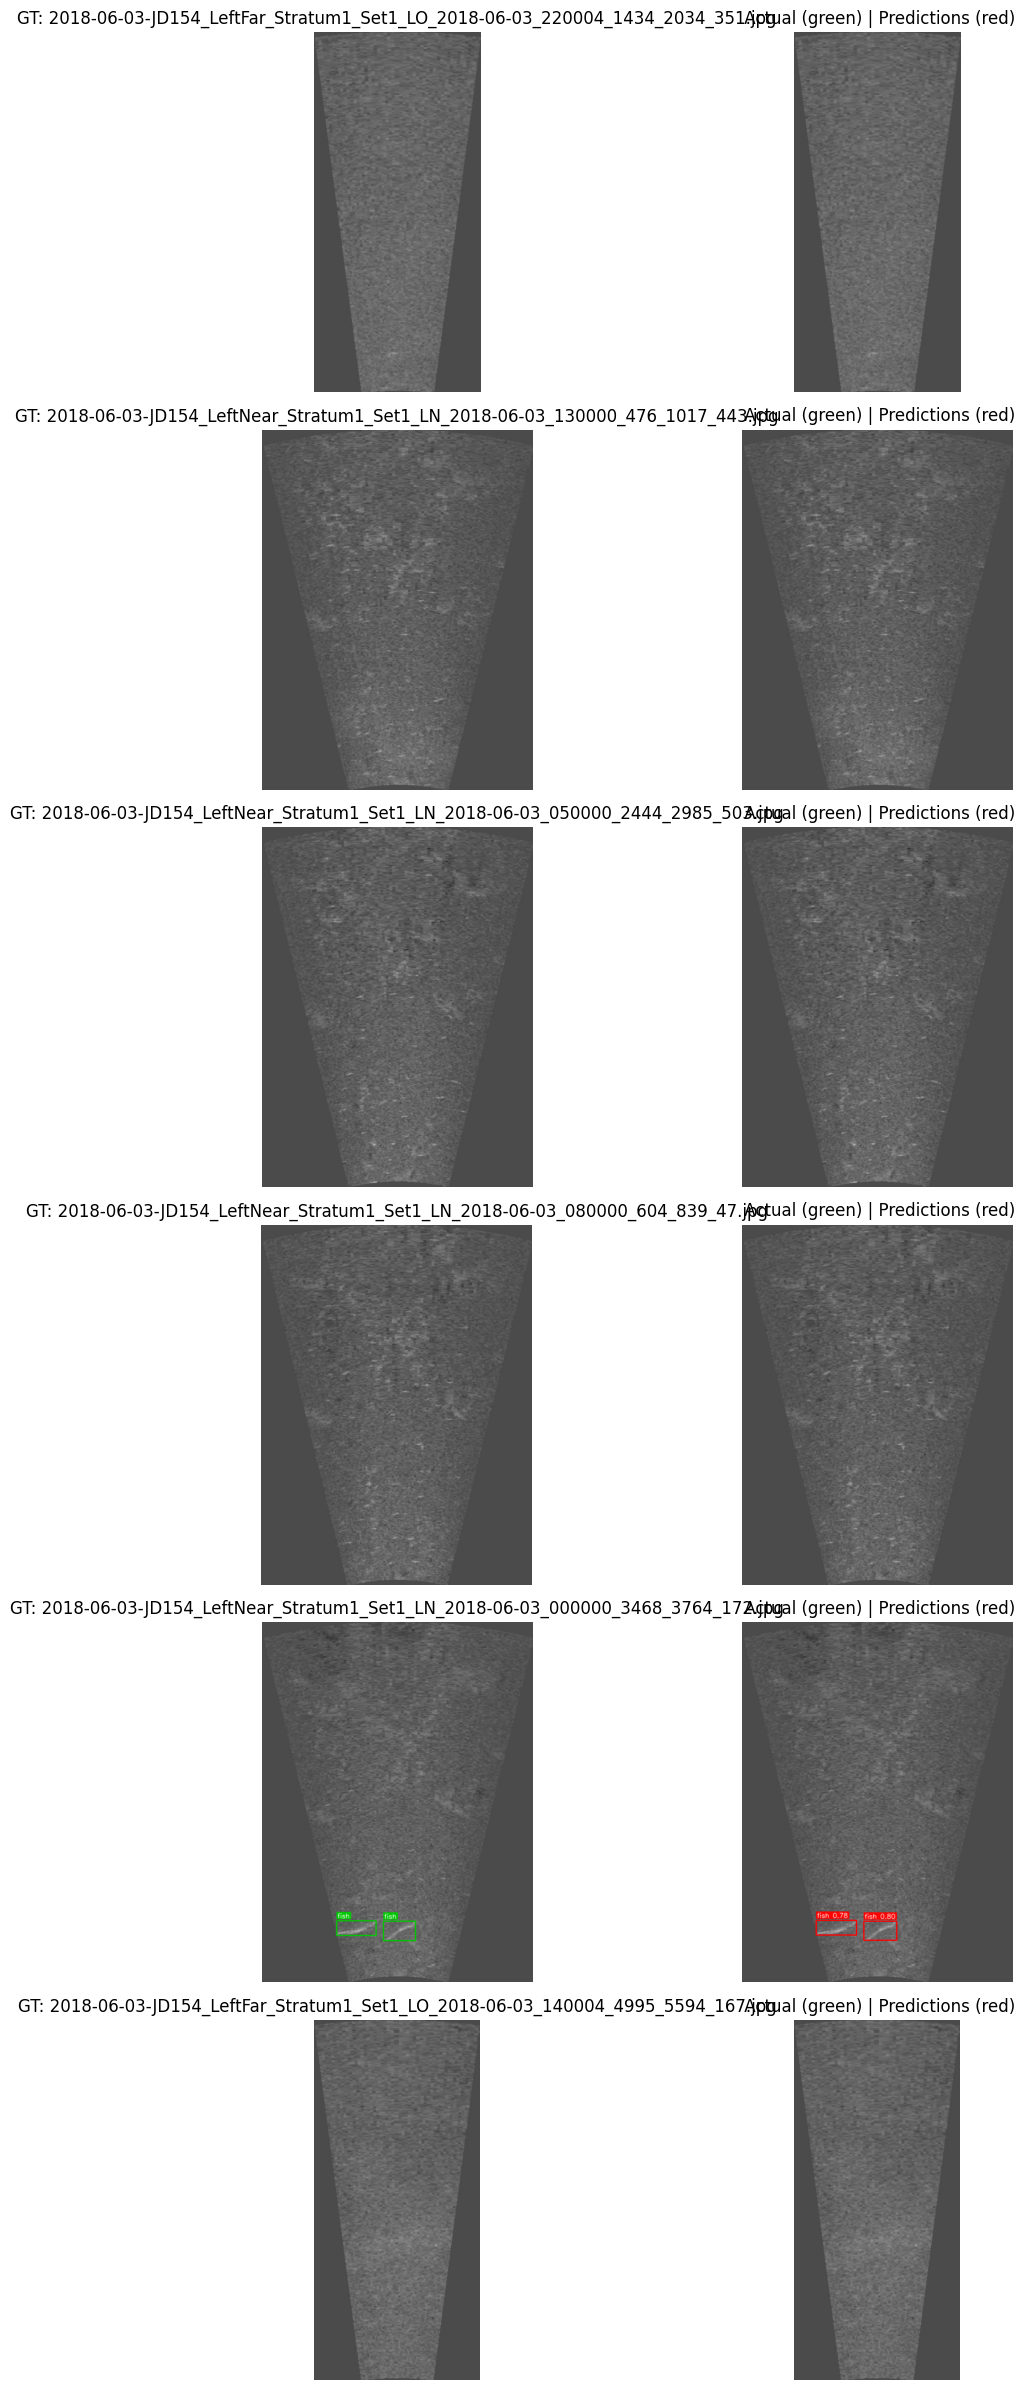

In [ ]:
import cv2, random, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

%matplotlib inline


# ---- Config ----
data_root = Path("../data/CFC_gray")
images_dir = data_root     / "images"/ "val"
labels_dir = data_root  / "labels"/ "val"
weights = "../runs_aquayolo/cfc_gray_adamW_m/weights/best.pt"

num_samples = 6      # how many random examples to show
conf_thres = 0.25    # prediction confidence threshold
imgsz = 640          # inference size

# ---- Load model ----
model = YOLO(weights)
names = model.names

# ---- Helpers ----
def yolo_txt_to_xyxy(txt_line, img_w, img_h):
    """Convert 'cls cx cy w h' (normalized) to xyxy pixel coords."""
    c, cx, cy, w, h = txt_line.strip().split()
    c = int(float(c))
    cx, cy, w, h = map(float, (cx, cy, w, h))
    x1 = (cx - w/2) * img_w
    y1 = (cy - h/2) * img_h
    x2 = (cx + w/2) * img_w
    y2 = (cy + h/2) * img_h
    return c, int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))

def draw_boxes(img, boxes, labels=None, color=(255, 0, 0), thickness=2):
    """Draw boxes [(x1,y1,x2,y2), ...] with optional label strings."""
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        if labels is not None:
            txt = labels[i]
            (tw, th), bl = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            ytxt = max(0, y1 - 4)
            cv2.rectangle(img, (x1, ytxt - th - 4), (x1 + tw + 4, ytxt), color, -1)
            cv2.putText(img, txt, (x1 + 2, ytxt - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return img

# ---- Collect images ----
image_paths = sorted([p for p in images_dir.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}])
random.shuffle(image_paths)
image_paths = image_paths[:num_samples]

# ---- Inference + plot ----
cols = 2
rows = len(image_paths)
plt.figure(figsize=(12, 4 * rows))

for idx, img_path in enumerate(image_paths, 1):
    # Load image
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"⚠️ Could not read {img_path}")
        continue
    h, w = img_bgr.shape[:2]

    # --- Ground truth ---
    gt_boxes, gt_labels = [], []
    lbl_path = labels_dir / (img_path.stem + ".txt")
    if lbl_path.exists():
        with open(lbl_path, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                c, x1, y1, x2, y2 = yolo_txt_to_xyxy(line, w, h)
                gt_boxes.append((x1, y1, x2, y2))
                gt_labels.append(names.get(c, str(c)))
    gt_img = img_bgr.copy()
    gt_img = draw_boxes(gt_img, gt_boxes, gt_labels, color=(0, 200, 0), thickness=2)  # green for GT

    # --- Predictions ---
    # Run model; get per-image results
    res = model.predict(str(img_path), imgsz=imgsz, conf=conf_thres, verbose=False)[0]
    pred_boxes, pred_labels = [], []
    if res.boxes is not None and len(res.boxes) > 0:
        xyxy = res.boxes.xyxy.cpu().numpy().astype(int)
        cls  = res.boxes.cls.cpu().numpy().astype(int)
        conf = res.boxes.conf.cpu().numpy()
        for (x1, y1, x2, y2), c, p in zip(xyxy, cls, conf):
            pred_boxes.append((x1, y1, x2, y2))
            pred_labels.append(f"{names.get(c, str(c))} {p:.2f}")
    pred_img = img_bgr.copy()
    pred_img = draw_boxes(pred_img, pred_boxes, pred_labels, color=(0, 0, 255), thickness=2)  # red for Pred

    # --- Matplotlib show (convert BGR->RGB) ---
    gt_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    pr_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, 2*(idx-1)+1)
    plt.imshow(gt_rgb)
    plt.title(f"GT: {img_path.name}")
    plt.axis("off")

    plt.subplot(rows, cols, 2*(idx-1)+2)
    plt.imshow(pr_rgb)
    plt.title(" Actual (green) | Predictions (red)")
    plt.axis("off")

plt.tight_layout()
plt.show()
